In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
import japanize_matplotlib
from PIL import Image
import os


In [ ]:
print(matplotlib.matplotlib_fname())

In [ ]:
print([f for f in font_manager.fontManager.ttflist if 'Nchifont+' in f.name])

matplotlib.rcParams['font.family'] = ['Nchifont+']


In [ ]:
print(matplotlib.get_cachedir())


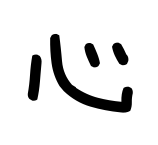

In [12]:
#This function turns text into a picture

def txt_img(txt):
    fig = plt.figure()
    fig.set_figheight(1.5)
    fig.set_figwidth(1.6)
    plt.axis('off')
    plt.text(-0.05, 0.03, txt, dict(size=100))
    plt.ioff()


txt_img('心')
plt.show()

In [4]:
#This is our dataset

df_json = pd.DataFrame(pd.read_json('kanji_extra.json')).T

df_extra = df_json.reset_index()[['index', 'strokes']].rename(columns={'index':'kanji'}).truncate(after=12155)
df_extra.head()
# df_extra_augmented = pd.concat([df_extra]*5, ignore_index=True)
# df_extra_augmented

,kanji,strokes
0,一,1
1,二,2
2,九,2
3,七,2
4,人,2


In [17]:
#This function takes each kanji from the dataframe, converts it into a grayscale image, and then the image into a numpy array and then appends it into a list called data

from scipy.ndimage import rotate

no = 0
data=[]
for i in df_extra['kanji']:
    txt_img(i)
    name = 'kanji_images_CNN_extra/kanji_' + str(no)+'.png'
    plt.savefig(name, dpi=25)
    no +=1
    # rot_img = np.array(Image.fromarray(np.array(Image.open(name).convert('L'))).rotate(fillcolor='white', angle=np.random.randint(360,size=1)))
    data.append(np.array(Image.open(name).convert('L')))
    # data.append(rot_img)


/var/folders/8h/mgykypr12rn6hfmp46xcxkwh0000gn/T/ipykernel_1315/3108409316.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


In [141]:
#normalise our data such that the range for each element is 0 to 1

data=np.array(data)/255
data.shape


array([[3.63713078e-15, 3.63713078e-15, 3.63713078e-15, ...,
        3.63713078e-15, 3.63713078e-15, 3.63713078e-15],
       [3.63713078e-15, 3.63713078e-15, 3.63713078e-15, ...,
        3.63713078e-15, 3.63713078e-15, 3.63713078e-15],
       [3.63713078e-15, 3.63713078e-15, 3.63713078e-15, ...,
        3.63713078e-15, 3.63713078e-15, 3.63713078e-15],
       ...,
       [3.63713078e-15, 3.63713078e-15, 3.63713078e-15, ...,
        3.63713078e-15, 3.63713078e-15, 3.63713078e-15],
       [3.63713078e-15, 3.63713078e-15, 3.63713078e-15, ...,
        3.63713078e-15, 3.63713078e-15, 3.63713078e-15],
       [3.63713078e-15, 3.63713078e-15, 3.63713078e-15, ...,
        3.63713078e-15, 3.63713078e-15, 3.63713078e-15]])

In [21]:
#Note that our maximun number of stroke is 33

df_extra['strokes'].max()

33

In [22]:
#split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, df_extra['strokes'].astype('int'), test_size=0.05, shuffle=True)

5760     14
6572     14
8372     18
2744     10
11021    12
         ..
6800      7
1639      6
3570     11
10659    13
10023    15
Name: strokes, Length: 11548, dtype: int64

In [7]:
#Time to build our model and train it

from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras import models

In [24]:
input_shape = (37, 40, 1)
num_classes = 35

model_path = '/Users/rashidalawadhi/Documents/GitHub/kanji_NN/kanji_model.hdf5'

x_train = np.expand_dims(X_train, -1)
x_test = np.expand_dims(X_test, -1)

# Model
model = keras.Sequential()


# Add convolution 2D
model.add(Conv2D(128, kernel_size=(3, 3),activation='relu', padding="same",
        kernel_initializer='he_normal',input_shape=input_shape))

model.add(BatchNormalization())

model.add(Conv2D(64,kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
# Add dropouts to the model
model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size=(3, 3), strides=1,padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), strides=1,padding='same', activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 37, 40, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 37, 40, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 38, 64)        73792     
                                                                 
 batch_normalization_1 (Batc  (None, 35, 38, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 35, 38, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 19, 64)       0

In [ ]:
batch_size = 64
epochs = 40

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='/Users/rashidalawadhi/Documents/GitHub/kanji_NN/checkpoints/model_kanji.h5',
    monitor= "val_loss",
    verbose = 0,
    save_freq='epoch',
    save_best_only =True,
    save_weights_only = True,
    mode =  "auto",
)

# opt = keras.optimizers.Adam(learning_rate=0.05)

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[checkpoint])



In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print(score)

In [ ]:
print('Average accuracy over '+str(epochs)+' epochs:',str((np.mean(history.history['val_accuracy'])*100).round(1))+' %','bach='+str(batch_size))
print('Average loss over '+str(epochs)+' epochs:',str((np.mean(history.history['val_loss'])).round(3)))
print(max(history.history['val_accuracy']),min(history.history['val_loss']))

Average accuracy over 40 epochs: 44.0 % bach=64
Average loss over 40 epochs: 1.378
0.6177489161491394 0.921973705291748


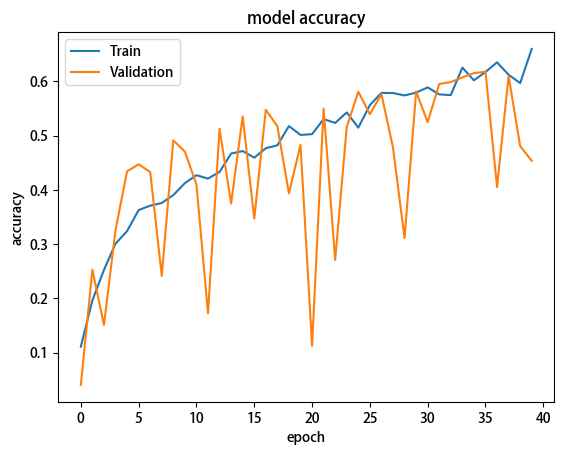

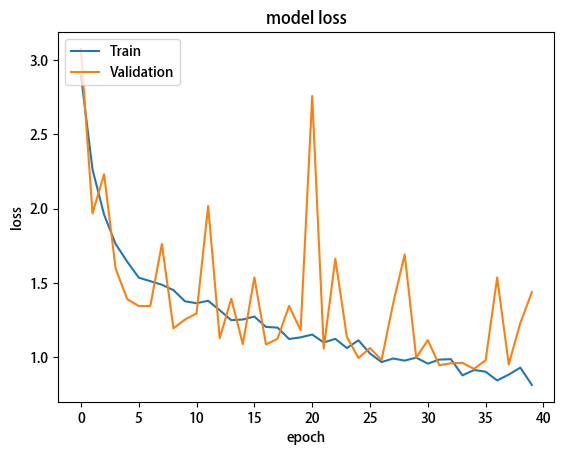

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [14]:
#Save model

from tensorflow.keras.models import load_model



In [15]:
#Uncomment to save model

# model.save('/Users/rashidalawadhi/Documents/GitHub/kanji_NN/models/kanjiCNN.h5')

In [16]:
new_model = load_model('/Users/rashidalawadhi/Documents/GitHub/kanji_NN/models/kanjiCNN.h5')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-18 13:00:43.837065: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-18 13:00:43.837179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
img_path = '/Users/rashidalawadhi/Documents/GitHub/kanji_NN/kanji_images_CNN_extra/kanji_144.png'

img_array = np.array(np.array(Image.open(img_path).convert('L'))/255)
print(img_array.shape)
imgtest = np.expand_dims(np.array(img_array), 0)
print(img_array.shape)
imgtest.shape

(37, 40)
(37, 40)


(1, 37, 40)

In [18]:
new_model.predict(imgtest).argmax()

1/1 [==============================] - 0s 150ms/step


2023-04-18 13:00:47.860003: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-18 13:00:47.916606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7

In [14]:
new_model.evaluate(x_test, y_test, verbose=0)

NameError: name 'x_test' is not defined

In [15]:
# new_model.summary()

In [28]:
test_path = '/Users/rashidalawadhi/Documents/GitHub/kanji_NN/diff_font'
txt_img('水')
# plt.savefig(test_path+'/tKanji.png',dpi=25)

no = 0
data=[]
for i in df_extra['kanji'][0:1000]:
    txt_img(i)
    name = 'diff_font/kanji_' + str(no)+'.png'
    plt.savefig(name, dpi=25)
    no +=1
    # rot_img = np.array(Image.fromarray(np.array(Image.open(name).convert('L'))).rotate(fillcolor='white', angle=np.random.randint(360,size=1)))
    data.append(np.expand_dims(np.array(Image.open(name).convert('L'))/255,axis=0))
    # data.append(rot_img)



In [29]:
# font_img = np.expand_dims(np.array(Image.open(test_path+'/tKanji.png').convert('L'))/255,0)
predicted_stroke = []
for i in data:
    predicted_stroke.append(new_model.predict(i, verbose=0).argmax())

In [50]:
correct_stroke = []
for i in df_extra['strokes'][0:1000]:
    correct_stroke.append(i)

In [51]:
tot_corr = 0
for i in range(0,1000):
    if predicted_stroke[i] == correct_stroke[i]:
        tot_corr +=1

In [52]:
str(tot_corr/(len(correct_stroke))*100)+'%'

'38.2%'